In [1]:
# Importación de librerías
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# Cargar el dataset desde la ruta relativa
ruta = '../Dataset/adult.data'
columnas = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
            'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
            'hours-per-week', 'native-country', 'income']
df = pd.read_csv(ruta, header=None, names=columnas, na_values=' ?')

df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Limpieza de datos: eliminamos filas con valores faltantes
df.dropna(inplace=True)

# Selección de variables predictoras
X = df[["age", "education-num", "hours-per-week", "workclass", "marital-status", "occupation", "race", "sex", "native-country"]]

# One-hot encoding para variables categóricas
X = pd.get_dummies(X, columns=["workclass", "marital-status", "occupation", "race", "sex", "native-country"], drop_first=True)

# Variable objetivo: ingreso
y = df["income"]
y = y.apply(lambda x: 1 if x.strip() == ">50K" else 0)

# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convertir a tensores
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


In [4]:
# Definir el modelo de red neuronal MLP
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),   # capa oculta 1
            nn.ReLU(),
            nn.Linear(64, 32),          # capa oculta 2
            nn.ReLU(),
            nn.Linear(32, 1),           # capa de salida
            nn.Sigmoid()                # Función de activación para clasificación binaria
        )

    def forward(self, x):
        return self.model(x)


In [5]:
# Inicialización del modelo
input_dim = X_train_tensor.shape[1]  # cantidad de columnas de entrada
model = MLPClassifier(input_dim)


In [6]:
# Definir el criterio de pérdida (Binary Cross-Entropy) y el optimizador (SGD)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 500
loss_history = []


In [9]:
# Cambiar el tipo de pérdida a MSELoss para regresión
criterion = nn.MSELoss()  # Para tareas de regresión

# Entrenamiento del modelo
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Realizamos la predicción
    outputs = model(X_train_tensor).squeeze()  # Eliminamos la dimensión extra

    # Aseguramos que la predicción y las etiquetas tengan la misma forma
    loss = criterion(outputs, y_train_tensor.squeeze())  # Squeeze en y_train_tensor para eliminar la dimensión extra

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Época {epoch}: Pérdida = {loss.item():.2f}")


Época 0: Pérdida = 1.23
Época 50: Pérdida = 1.01
Época 100: Pérdida = 0.94
Época 150: Pérdida = 0.89
Época 200: Pérdida = 0.82
Época 250: Pérdida = 0.79
Época 300: Pérdida = 0.77
Época 350: Pérdida = 0.77
Época 400: Pérdida = 0.76
Época 450: Pérdida = 0.76
Época 499: Pérdida = 0.76


C:\Users\antra\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


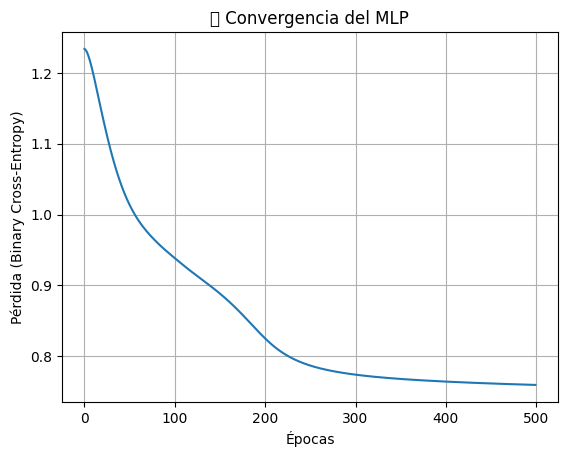

In [10]:
# Gráfica de la pérdida durante el entrenamiento
plt.plot(loss_history)
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Binary Cross-Entropy)")
plt.title("📉 Convergencia del MLP")
plt.grid(True)
plt.show()


In [11]:
# Predicción
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

# Convertimos las predicciones a 0 o 1
y_pred_class = [1 if val >= 0.5 else 0 for val in y_pred_scaled]

# Calcular métricas
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred_class)
report = classification_report(y_test, y_pred_class)

print(f"✅ Precisión: {accuracy:.4f}")
print("📋 Reporte de clasificación:")
print(report)


✅ Precisión: 0.8265
📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4503
           1       0.68      0.60      0.64      1530

    accuracy                           0.83      6033
   macro avg       0.77      0.75      0.76      6033
weighted avg       0.82      0.83      0.82      6033



C:\Users\antra\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


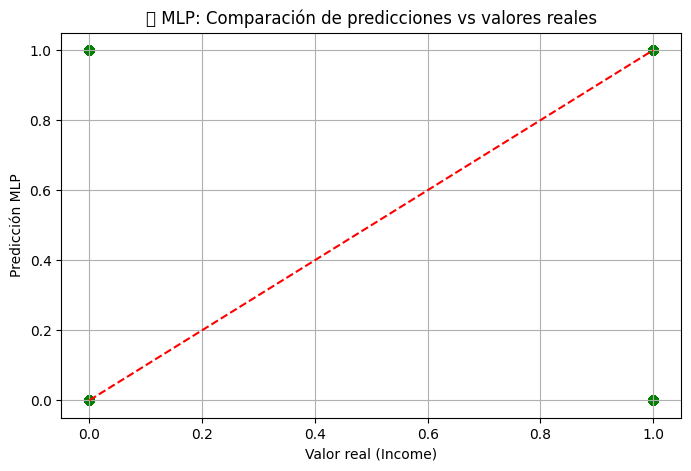

In [12]:
# Graficar la comparación de las predicciones vs valores reales
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_class, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valor real (Income)")
plt.ylabel("Predicción MLP")
plt.title("🎯 MLP: Comparación de predicciones vs valores reales")
plt.grid(True)
plt.show()
